<a href="https://colab.research.google.com/github/HenriqueCCdA/BC_DS_Projeto_Final/blob/main/Notebooks/ML/treinamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# 1) Resumo

Neste notebook foram feitos os treinamentos e seleção de hyperparamentros de 6 modelos de **ML** distintos. Os modelos estudados foram:

* DummyClassifier
* LogisticRegression
* DecisionTreeClassifier
* Forest Tree
* Support Vector Machine
* KNeighbors

A busca pelos hyperparametros foram feitas pelo GridSearchCV ou pelo RandomizedSearchCV. Para a Cross Validation foi usado **RepeatedStratifiedKFold** com **5** divições de **10** repetições.

O parametro utilizado para avaliação do modelo foi **ROC_AUC** e quantidade de **falsos negativos** (FN).

A base de dados utilizados tem **351** amostras com **52** variaveis explicativas. Dessas **351** amostras **298** foram usados para **Cross Validation** (treino + teste) e **53** foram usados para a **validação**.


---
# 2) Pre-analise

---
## 2.1) Minhas Funções

In [1]:
collab=False #Notebook roda no collab ?  

if (collab):
  !curl -O "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/plota_graficos.py"
  !pip install matplotlib==3.4.2 scikit-learn==0.24.2
  !curl -O "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/plota_graficos.py"
  !curl -O "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/ml.py"
  !curl -O "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/info.py"

  from plota_graficos import plota_treino_teste_auc, plota_curva_roc, plota_matriz_de_confusao
  from ml import retorna_x_y, intervalo_de_confianca, treina_modelo_grid_search_cv,\
                 treina_modelo_randomized_search_cv, obtem_os_resultados_SearchCV, cv_val_split, desempenho_dos_modelos

  from info import proporcao_y, numero_teste_treino_val, resultados_treinamento, dimensao_dados, variaveis_explicativas

else:
  import sys
  sys.path.insert(1, "../../")

  from src.plota_graficos import plota_treino_teste_auc, plota_curva_roc, plota_matriz_de_confusao
  from src.ml import retorna_x_y, intervalo_de_confianca, treina_modelo_grid_search_cv,\
                   treina_modelo_randomized_search_cv, obtem_os_resultados_SearchCV, cv_val_split, desempenho_dos_modelos 

  from src.info import proporcao_y, numero_teste_treino_val, resultados_treinamento, dimensao_dados, variaveis_explicativas

---
## 2.2) Importando libs

In [2]:
import pandas as pd
#
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#
import matplotlib.pyplot as plt
#
import numpy as np
#
from scipy.stats import uniform

## 2.3) Versão dos bibilotecas

In [3]:
import sklearn as sk
import scipy   as sc
import matplotlib as mpl

print(f'scipy      : {sc.__version__}')
print(f'sklearn    : {sk.__version__}')
print(f'pandas     : {pd.__version__}')
print(f'numpy      : {np.__version__}')
print(f'matplotlib : {mpl.__version__}')


scipy      : 1.6.2
sklearn    : 0.24.2
pandas     : 1.2.4
numpy      : 1.20.2
matplotlib : 3.3.4


In [6]:
def treina(modelo, x, y, parameters, n_splits, n_repeats, n_iter, seed, titulo):
    '''
    ----------------------------------------------------------------------------
    Treina e mostra os resultados
    ----------------------------------------------------------------------------
    '''

    resultados, melhor_modelo, hyperparametros  =\
        treina_modelo_randomized_search_cv(modelo,
                                          x_cv,
                                          y_cv,
                                          parameters,
                                          n_splits=n_splits,
                                          n_repeats=n_repeats,
                                          n_iter=n_iter,
                                          seed=seed)

    plota_treino_teste_auc(titulo, 
                         resultados['media_teste'],
                         resultados['media_treino'],
                         resultados['rank_test_score'],
                         hyperparametros)

    resultados_treinamento(resultados, melhor_modelo, hyperparametros, n = 10)

    return melhor_modelo

---
# 3) Lendo os dados

In [7]:
path = "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/Dados/Tratados/dados_sem_coor_acima_do_valor_de_corte.csv"

dados_com_corte = pd.read_csv(path)

dimensao_dados(dados_com_corte)

dados_com_corte.tail(n=5)

Numero de linhas : 351 
Numero de colunas: 53 


,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MAX,ICU
346,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.860241,-0.978029,-0.160494,-0.692308,0.339623,-0.457627,0.142857,0.736842,-0.418803,1
347,1,1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.855422,-0.978029,-0.407407,-0.692308,-0.283019,-0.457627,-0.059524,0.526316,-0.589744,0
348,0,-0.111111,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.787952,-0.964461,0.012346,-0.384615,-0.320755,-0.457627,-0.071429,0.894737,-0.299145,1
349,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.937349,-0.978029,0.086420,-0.230769,-0.301887,-0.661017,-0.107143,0.736842,-0.247863,0
350,0,-0.111111,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.879518,-0.979571,0.012346,-0.292308,0.056604,-0.525424,0.535714,0.789474,-0.299145,0


In [8]:
dados_com_corte.describe()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MAX,ICU
count,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,...,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.458689,-0.046534,0.381766,0.108262,0.022792,0.091168,0.019943,0.128205,0.045584,0.196581,...,-0.841746,-0.960159,-0.045990,-0.318411,-0.240403,-0.468207,0.097772,0.760029,-0.313074,0.461538
std,0.499002,0.640366,0.486513,0.311155,0.149453,0.288259,0.140004,0.334795,0.208879,0.397980,...,0.135197,0.098682,0.253692,0.274796,0.278347,0.213326,0.272230,0.116880,0.185592,0.499230
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.971084,-1.000000,-0.654321,-0.938462,-0.823899,-0.954802,-0.571429,0.263158,-0.760684,0.000000
25%,0.000000,-0.555556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.898795,-0.983811,-0.185185,-0.538462,-0.415094,-0.593220,-0.107143,0.684211,-0.418803,0.000000
50%,0.000000,-0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.874699,-0.978029,-0.037037,-0.369231,-0.283019,-0.525424,0.071429,0.789474,-0.299145,0.000000
75%,1.000000,0.555556,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.821687,-0.971784,0.086420,-0.153846,-0.094340,-0.389831,0.250000,0.842105,-0.213675,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.513241,0.604938,0.553846,1.000000,0.830508,0.964286,1.000000,0.487179,1.000000


In [9]:
_ = variaveis_explicativas(dados_com_corte)

 col[  0] -> AGE_ABOVE65                    col[  1] -> AGE_PERCENTIL                  
 col[  2] -> GENDER                         col[  3] -> DISEASE GROUPING 1             
 col[  4] -> DISEASE GROUPING 2             col[  5] -> DISEASE GROUPING 3             
 col[  6] -> DISEASE GROUPING 4             col[  7] -> DISEASE GROUPING 5             
 col[  8] -> DISEASE GROUPING 6             col[  9] -> HTN                            
 col[ 10] -> IMMUNOCOMPROMISED              col[ 11] -> OTHER                          
 col[ 12] -> ALBUMIN_MEDIAN                 col[ 13] -> BE_ARTERIAL_MEDIAN             
 col[ 14] -> BE_VENOUS_MEDIAN               col[ 15] -> BIC_VENOUS_MEDIAN              
 col[ 16] -> BILLIRUBIN_MEDIAN              col[ 17] -> BLAST_MEDIAN                   
 col[ 18] -> CALCIUM_MEDIAN                 col[ 19] -> CREATININ_MEDIAN               
 col[ 20] -> FFA_MEDIAN                     col[ 21] -> GGT_MEDIAN                     
 col[ 22] -> GLUCOSE_MEDIAN     

### Divindido os dados em validação e Cross Valadiation (teste+treino)

In [10]:
x_cv, x_val, y_cv, y_val = cv_val_split(dados_com_corte, p_val = .15)

### Verificando se a proporção foi mantida 

In [11]:
proporcao_y(dados_com_corte['ICU'])
proporcao_y(y_val)
proporcao_y(y_cv )

Proporcao do ICU
Campo 0 ->  53.85%
Campo 1 ->  46.15%
Proporcao do ICU
Campo 0 ->  54.72%
Campo 1 ->  45.28%
Proporcao do ICU
Campo 0 ->  53.69%
Campo 1 ->  46.31%


In [12]:
numero_teste_treino_val(dados_com_corte['ICU'], y_val, y_cv)

Número total de entradas                         : 351
Número total de entradas para validacao          : 53
Número total de entradas para o Cross Validation : 298


# 4) Modelo de ML

A opção **refit** foi deixado como **true** logo depois que o melhor modelo for selecioando o RandomizedSearchCV/GridSearchCv **re-treina** esse modelo com o dataset completo (treino+teste). 

In [13]:
n_iter   = 20
n_splits = 5
n_repeats= 10
seed     = 14715

## 4.1) DummyClassifier

> Aqui será treinado do modelo **DummyClassifier**. Para o treino foi usado **GridSearchCV**. O único hyperparametro disponivel foi **strategy**. O intervalor de busca  **[stratified, 'ost_frequent, prior, 'uniform]**. O DummyClassifier será usado como o nosso modelo **"baseline"**



In [14]:
modelo = DummyClassifier(random_state=141715)

parameters = {'strategy' : ['stratified', 'most_frequent', 'prior', 'uniform']}

resultados, melhor_modelo_dummy, melhores_hyperparametros  = treina_modelo_grid_search_cv(modelo,
                                                                                      x_cv,
                                                                                      y_cv,
                                                                                      parameters,
                                                                                      n_splits=n_splits,
                                                                                      n_repeats=n_repeats,
                                                                                      seed=14715)

resultados_treinamento(resultados, melhor_modelo_dummy, melhores_hyperparametros)

Fitting 50 folds for each of 4 candidates, totalling 200 fits
melhores hyperparametros : {'strategy': 'stratified'}
Melhor modelo            : DummyClassifier(random_state=141715, strategy='stratified')


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,{'strategy': 'stratified'},0.50495,0.488167,0.068442,0.029206,0.002279,0.001549,0.003578,0.003724,1
1,{'strategy': 'most_frequent'},0.50000,0.500000,0.000000,0.000000,0.001904,0.000642,0.002898,0.000700,2
2,{'strategy': 'prior'},0.50000,0.500000,0.000000,0.000000,0.001959,0.000870,0.002998,0.000999,2
3,{'strategy': 'uniform'},0.50000,0.500000,0.000000,0.000000,0.001719,0.000530,0.002818,0.000909,2


---
## 4.2) Regreção logistica

> Aqui será treinado do modelo **LogisticRegression**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros foram:
>* C             : [0, 4]


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


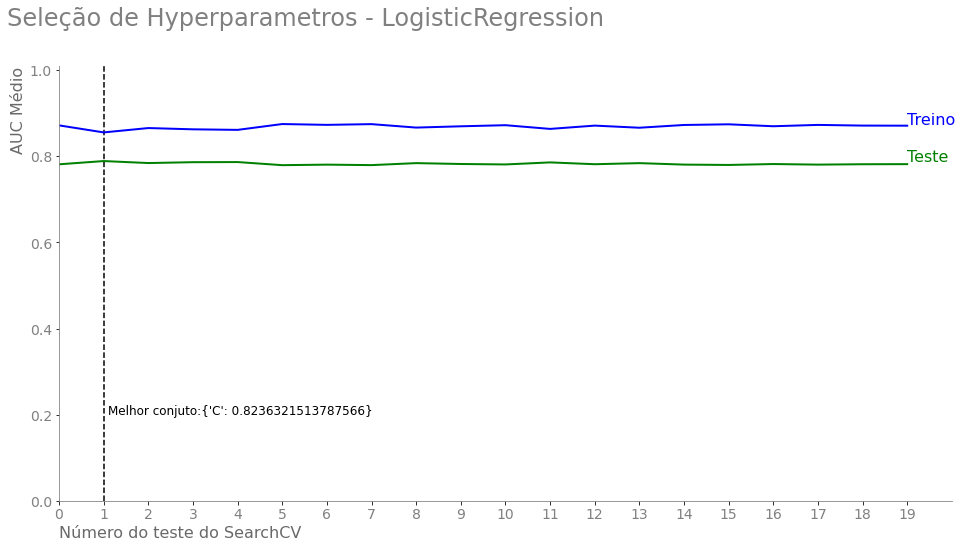

melhores hyperparametros : {'C': 0.8236321513787566}
Melhor modelo            : LogisticRegression(C=0.8236321513787566, max_iter=1000, tol=1e-06)


In [15]:
parameters = {'C': uniform(loc=0, scale=4)}
modelo = LogisticRegression(max_iter=1000, tol=1e-6)

melhor_modelo_lr =treina(modelo = modelo,
                        x = x_cv, 
                        y = y_cv, 
                        parameters = parameters, 
                        n_splits = n_splits, 
                        n_repeats = n_repeats, 
                        n_iter = n_iter, 
                        seed = seed, 
                        titulo = 'Seleção de Hyperparametros - LogisticRegression')

---
## 4.3) Arvore de decissão

> Aqui será treinado do modelo **DecisionTreeClassifier**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros foram:
>* max_depth       : [1-20]
>* criterion       : [gini, entropy]
>* min_samples_leaf: [1-5]
>* max_leaf_nodes  : [2-5]


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


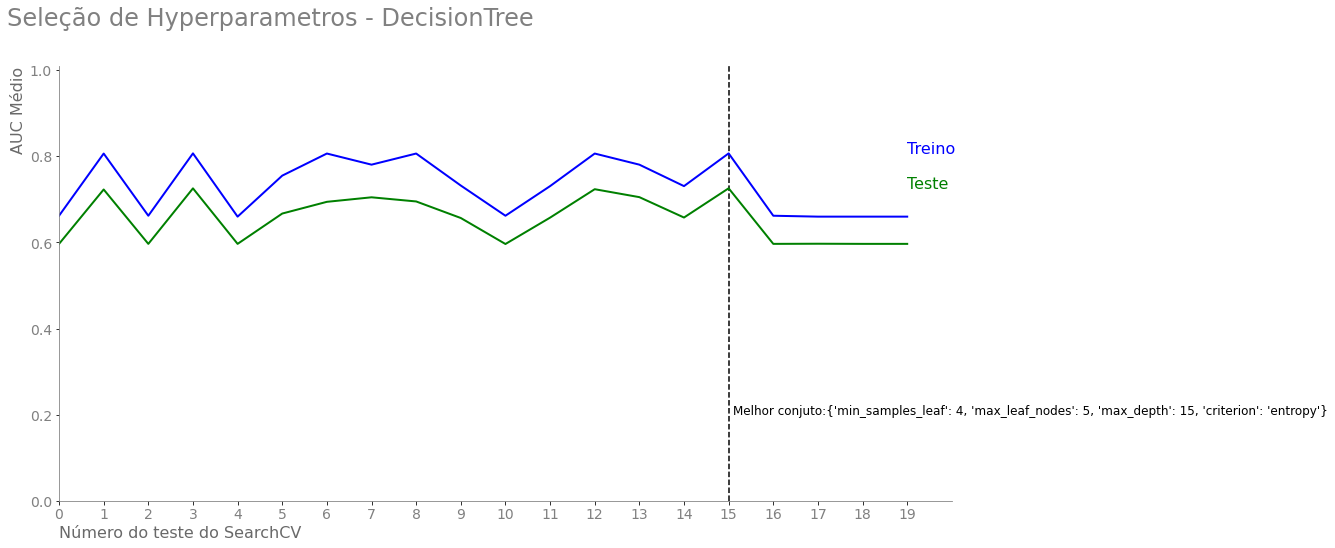

melhores hyperparametros : {'min_samples_leaf': 4, 'max_leaf_nodes': 5, 'max_depth': 15, 'criterion': 'entropy'}
Melhor modelo            : DecisionTreeClassifier(criterion='entropy', max_depth=15, max_leaf_nodes=5,
                       min_samples_leaf=4)


In [16]:
parameters = {'max_depth'       : np.arange(1, 21),
              'criterion'       : ['gini', 'entropy'],
              'min_samples_leaf': np.arange(1, 6),
              'max_leaf_nodes'  : np.arange(2, 6)
             }
modelo = DecisionTreeClassifier()

melhor_modelo_arvore = treina(modelo = modelo,
                            x = x_cv, 
                            y = y_cv, 
                            parameters = parameters, 
                            n_splits = n_splits, 
                            n_repeats = n_repeats, 
                            n_iter = n_iter, 
                            seed = seed, 
                            titulo = 'Seleção de Hyperparametros - DecisionTree')

---
## 4.4) Forest Tree

> Aqui será treinado do modelo **Forest Tree**. No treino foi usado **RandomizedSearchCV** com **10** iterações. Os hyperparametros foram:
>* n_estimators    : [10, 50, 100, 150, 200]
>* max_depth       : [1, 20]    
>* criterion       : [gini, entropy]
>* min_samples_leaf: [1-5]
>* max_leaf_nodes  : [2-5]


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


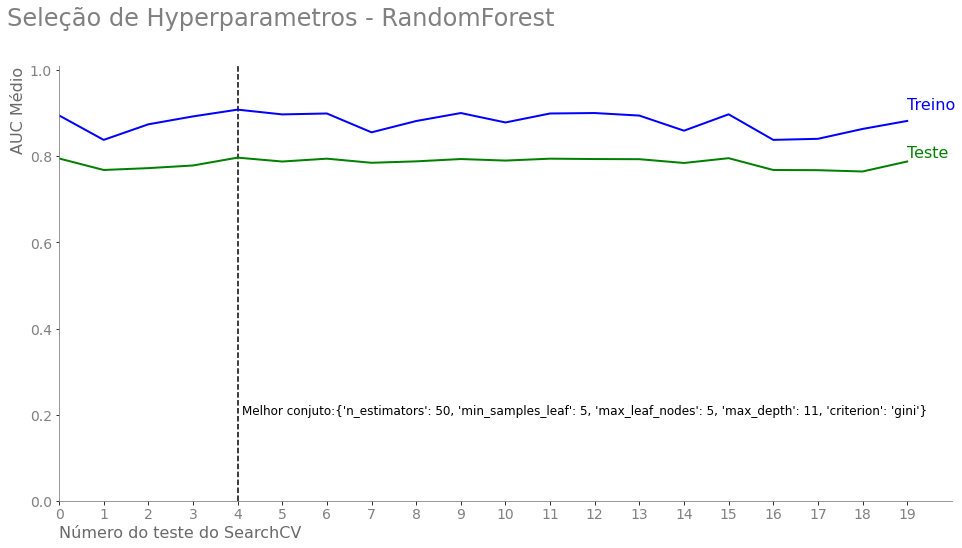

melhores hyperparametros : {'n_estimators': 50, 'min_samples_leaf': 5, 'max_leaf_nodes': 5, 'max_depth': 11, 'criterion': 'gini'}
Melhor modelo            : RandomForestClassifier(max_depth=11, max_leaf_nodes=5, min_samples_leaf=5,
                       n_estimators=50, random_state=0)


In [35]:
parameters = {'n_estimators'    : [10, 50, 100, 150, 200],
              'max_depth'       : np.arange(1, 21),
              'criterion'       : ['gini', 'entropy'],
              'min_samples_leaf': np.arange(1, 6),
              'max_leaf_nodes'  : np.arange(2, 6)
             }
modelo = RandomForestClassifier(random_state=0)

melhor_modelo_forest = treina(modelo = modelo,
                              x = x_cv, 
                              y = y_cv, 
                              parameters = parameters, 
                              n_splits = n_splits, 
                              n_repeats = n_repeats, 
                              n_iter = n_iter, 
                              seed = seed, 
                              titulo = 'Seleção de Hyperparametros - RandomForest')

> 

## 4.5) Support Vector Classification.

> Aqui será treinado do modelo **SVC**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros de busca foram
>* kernel        : [linear, poly, rbf, sigmoid]
>* C             : [0, 2]
>* gamma         : [scale, auto]
>* shrinking     : [True , False]

Fitting 50 folds for each of 20 candidates, totalling 1000 fits


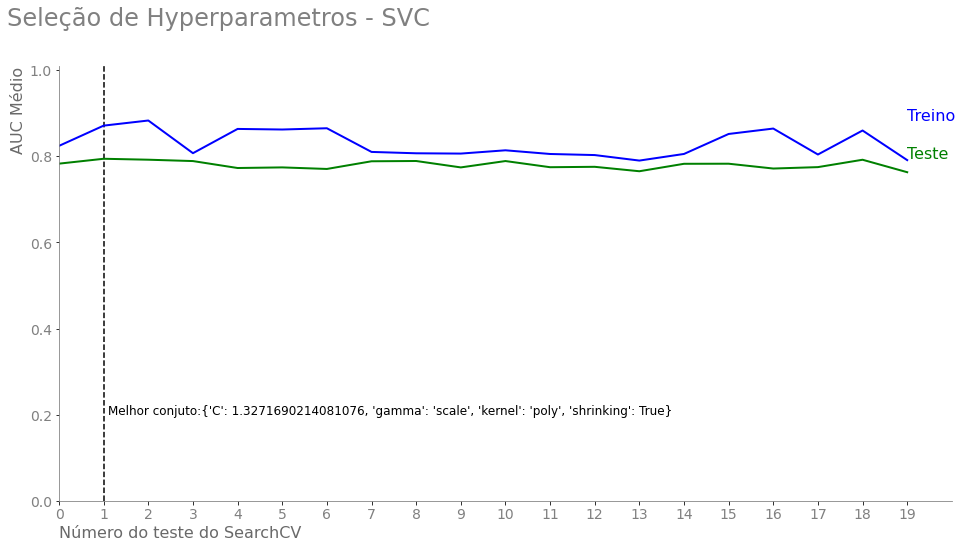

melhores hyperparametros : {'C': 1.3271690214081076, 'gamma': 'scale', 'kernel': 'poly', 'shrinking': True}
Melhor modelo            : SVC(C=1.3271690214081076, kernel='poly', probability=True)


In [37]:
parameters = {'kernel'          : ['linear', 'poly', 'rbf', 'sigmoid'],
              'C'               : uniform(loc=0, scale=2),
              'gamma'           : ['scale', 'auto'],
              'shrinking'       : [True, False]
             }

modelo = SVC(probability=True)

melhor_modelo_svc = treina(modelo = modelo,
                              x = x_cv, 
                              y = y_cv, 
                              parameters = parameters, 
                              n_splits = n_splits, 
                              n_repeats = n_repeats, 
                              n_iter = n_iter, 
                              seed = seed, 
                              titulo = 'Seleção de Hyperparametros - SVC')

## 4.5) KNeighbors

> Aqui será treinado do modelo **KNeighbor**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros de busca foram
>* n_neighbors   : [1, 10]
>* p             : [1, 2]
>* weights       : [uniform, distance]
>* algorithm     : [auto, ball_tree, kd_tree, brute]

Fitting 50 folds for each of 20 candidates, totalling 1000 fits


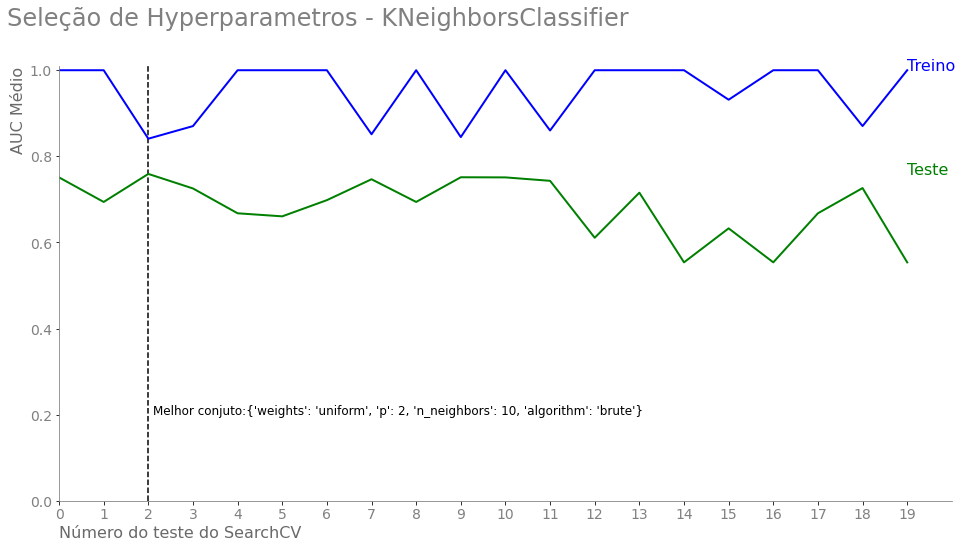

melhores hyperparametros : {'weights': 'uniform', 'p': 2, 'n_neighbors': 10, 'algorithm': 'brute'}
Melhor modelo            : KNeighborsClassifier(algorithm='brute', n_neighbors=10)


In [38]:
parameters = {'n_neighbors'     : np.arange(1, 11),
              'p'               : [1, 2],
              'weights'         : ['uniform', 'distance'],
              'algorithm'       : ['auto', 'ball_tree', 'kd_tree', 'brute']
             }

modelo = KNeighborsClassifier()

melhor_modelo_kn = treina(modelo = modelo,
                              x = x_cv, 
                              y = y_cv, 
                              parameters = parameters, 
                              n_splits = n_splits, 
                              n_repeats = n_repeats, 
                              n_iter = n_iter, 
                              seed = seed, 
                              titulo = 'Seleção de Hyperparametros - KNeighborsClassifier')


# 5) Avaliando o melhor modelo

> Agora vamos avaliar o melhor modelo encontrado utilizando o dados de validação.

In [43]:
modelos = [melhor_modelo_dummy, 
           melhor_modelo_lr, 
           melhor_modelo_arvore, 
           melhor_modelo_forest, 
           melhor_modelo_svc,
           melhor_modelo_kn] 

In [44]:
desempenho_dos_modelos(modelos, x_val, y_val)

,Name,tn,fp,fn,tp,AUC
0,LogisticRegression,24,5,13,11,0.728448
1,SVC,22,7,11,13,0.712644
2,RandomForestClassifier,22,7,13,11,0.699713
3,DecisionTreeClassifier,19,10,8,16,0.692529
4,KNeighborsClassifier,26,3,21,3,0.657328
5,DummyClassifier,12,17,17,7,0.352730


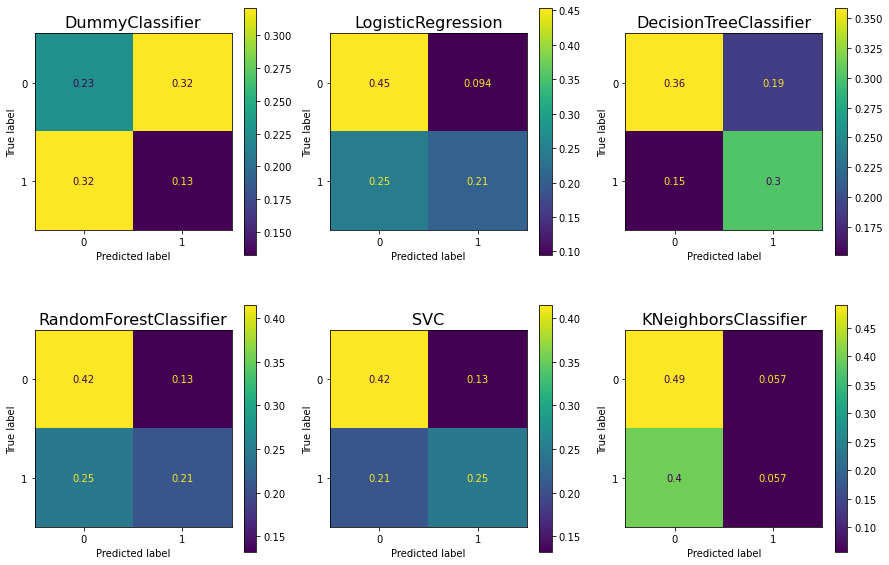

In [45]:
plota_matriz_de_confusao(modelos, x_val, y_val)

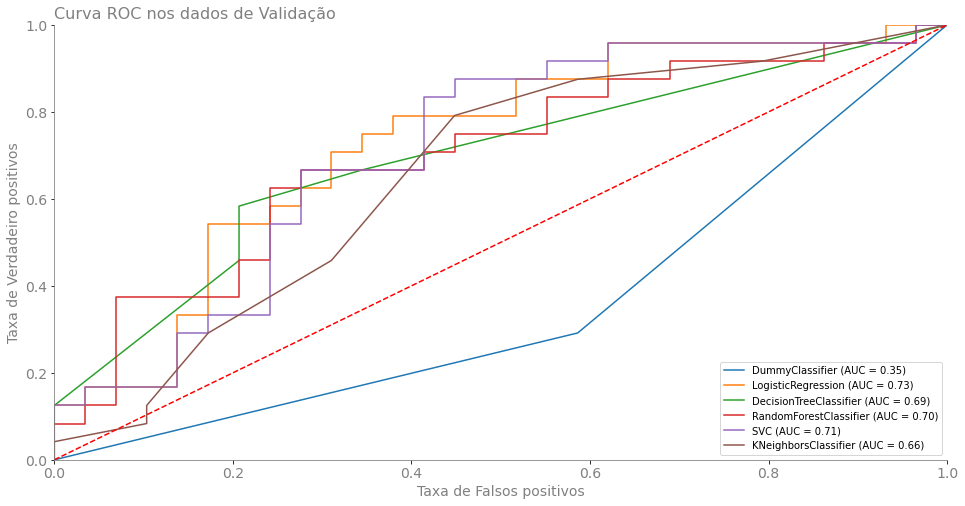

In [46]:
plota_curva_roc(modelos, titulo='Curva ROC nos dados de Validação', x=x_val, y=y_val)

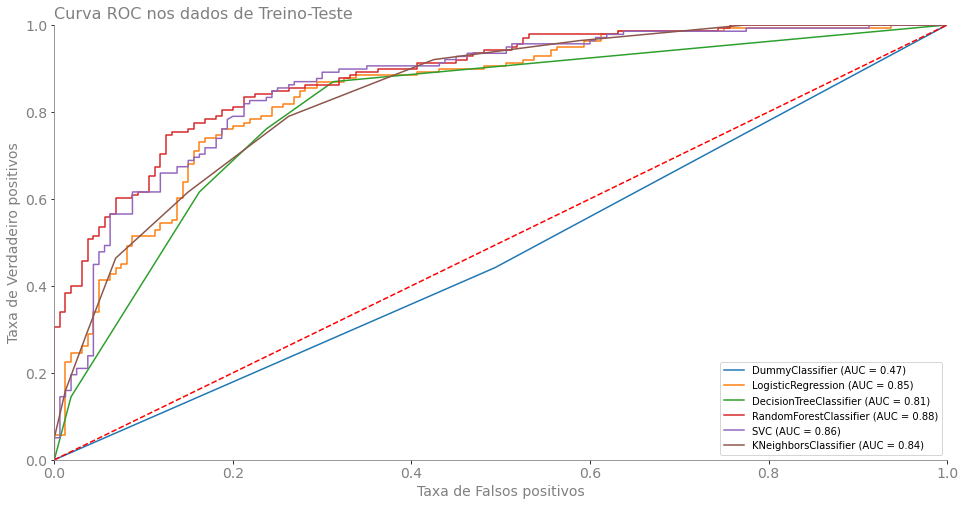

In [47]:
plota_curva_roc(modelos, titulo='Curva ROC nos dados de Treino-Teste', x=x_cv, y=y_cv)